Aluno: Jean Antonio Ribeiro<br>
RA: 265739

# Brain MRI classification using SVM

Nesta atividade o objetivo é classificar imagens de ressonância magnética do cérebro em imagens com tumor (*tumor*) e imagens sem tumor (*health*). Para simplificar a tarefa, as imagens já foram processadas e, ao invés de serem fornecidas como imagens volumétricas (3D) em formato DICOM, elas estão sendo fornecidas como fatias (imagens 2D) e no formato jpg.

O classificador a ser utilizado para a tarefa é o SVM (suport vector machine) e deverá ser usado o *pipeline* de classificação tradicional, ou seja, as imagens precisam ser processadas e os atributos devem ser extraídos, para serem depois usados no treinamento do SVM.

Este notebook mostra como se faz para carregar as imagens, extrair alguns atributos simples, treinar o SVM e visualizar os resultados. O atributo escolhido, histograma do LBP, apesar de apresentar uma acurácia aceitável, apresenta uma especificidade muito baixa. Você verá que há linhas comentadas ao longo do código, deixadas de propósito como exemplo de formas alternativas de tratar os dados.

Você deve tentar alterar o notebook, focando no processamento das imagens, escolha e extração de atributos, com o objetivo de melhorar a classificação das imagens.

In [39]:
# Imports

import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os
import glob
import copy
from PIL import Image

# connect drive
#from google.colab import drive
#drive.mount('/content/gdrive')

#!ls 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

## **Parte 1 - Carregando os dados (imagens e rótulos)**

Quando tentamos resolver um problema de classificação e vamos treinar um algoritmo supervisionado, precisamos de 3 conjuntos de dados: **treino**, **validação** e **teste**: 

- O conjunto de **treino** é o que será apresentado ao algoritmo, junto com o gabarito (rótulo, label, ground-thruth), e o algoritmo tentará aprender os padrões que separam as classes. 
- O conjunto de **validação** serve para testar se o algoritmo aprendeu, da seguinte forma: o modelo irá tentar predizer a saída e comparar com o rótulo daquela imagem de validação. Baseado nos erros e acertos no conjunto de validação, o algoritmo tenta ajustar seu modelo e predizer novamente. 
- O conjunto de **teste** só deve ser usado depois que o algoritmo já ajustou o modelo, para dar uma medida final de desempenho (acerto) do seu algoritmo.

Neste exemplo, para facilitar o trabalho de todos e garantir a comparação entre os resultados, os dados já estão organizados em 3 pastas: treino, validação e teste. Cada pasta contém as imagens e o rótulo de cada imagem (label). Lembrando que os dois rótulos possíveis são: *tumor* e *health*.

In [40]:
DATA_DIR = './DataSets/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/JeanKusanagi/DataSets ./DataSets')
    print('Done!')

import pathlib
PATH = "/content/DataSets/Brain_Tumor/"
PATH = pathlib.Path(PATH)

In [41]:
# Criação dos 3 subconjuntos de dados: train, val e test
# Dicionario de nome dataset com 3 grupos que contêm tanto images de sujeitos saudáveis quanto de pacientes com tumor.

#data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'

subsets = ['train', 'val', 'test']
labels = ['tumor', 'health']

dataset = {
    "train": [],
    "val": [],
    "test": [],
}

for subset in subsets:
  for label in labels:
    print('loading ... ', subset, label, ' ...')
    file_list = glob.glob(data_dir + subset + '/' + label + '/*')

    for file in file_list:
      image = Image.open(file)
      # print(file, image.format, image.size, image.mode)
      # image = image - np.min(image) #normalização
      # image = (image/np.max(image)) #normalização
      dataset[subset].append((image, label))

    print('randomizing subgroup')
    random.shuffle(dataset[subset])

loading ...  train tumor  ...
randomizing subgroup
loading ...  train health  ...
randomizing subgroup
loading ...  val tumor  ...
randomizing subgroup
loading ...  val health  ...
randomizing subgroup
loading ...  test tumor  ...
randomizing subgroup
loading ...  test health  ...
randomizing subgroup


In [42]:
# Imprimindo informações sobre os dados

groups_len = {
    "train": [],
    "val": [],
    "test": [],
}

for subset in subsets:
  print(subset)
  subset_size = len(dataset[subset])
  subset_health_size = len([x for x in range(len(dataset[subset])) if dataset[subset][x][1] == 'health'])
  subset_tumor_size = subset_size - subset_health_size
  print('subgroug size = ', subset_size)
  groups_len[subset] = [subset_size, subset_health_size, subset_tumor_size]
  print('health subgroug size = ', subset_health_size, ' - ', (subset_health_size/subset_size)*100, '%')
  print('tumor subgroug size = ', subset_tumor_size, ' - ', (subset_tumor_size/subset_size)*100, '%')


train
subgroug size =  176
health subgroug size =  69  -  39.20454545454545 %
tumor subgroug size =  107  -  60.79545454545454 %
val
subgroug size =  51
health subgroug size =  19  -  37.254901960784316 %
tumor subgroug size =  32  -  62.745098039215684 %
test
subgroug size =  26
health subgroug size =  10  -  38.46153846153847 %
tumor subgroug size =  16  -  61.53846153846154 %


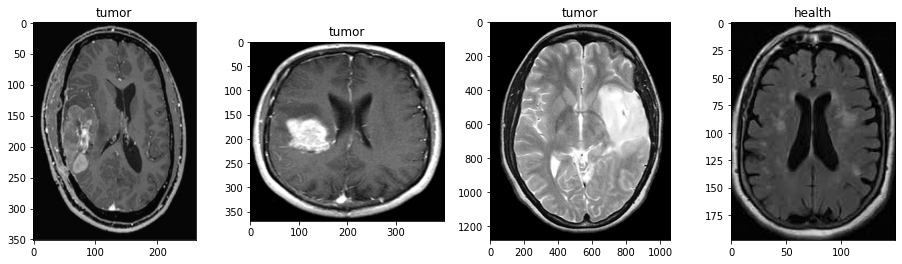

In [43]:
# Visualizando algumas imagens

def adjust_dimension(img): # algumas imagens possuem apenas 1 canal e algumas possuem 3. Essa função faz todas terem apenas 1 canal.
    if len(np.array(img).shape) > 2:
      return np.average(np.array(img), axis=2)
    else:
      return np.array(img)

# imagens de exemplo
plt.figure(figsize=(16, 4))
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(adjust_dimension(dataset['val'][i][0]),cmap='gray')
  plt.title(dataset['val'][i][1])
plt.show()

##**Parte 2 - Extraindo atributos (features)**

Como vimos no vídeo sobre atributos extraídos de imagens, a escolha dos atributos a serem utilizados depende do domínio e do problema a ser resolvido. O que vocês devem pensar é: "quais os atributos devem ter a capacidade de discriminar imagens com e sem tumor"? Abaixo há alguns exemplos de atributos que foram citados em aula, mas você pode decidir extrair outros atributos para resolver melhor o problema.


**1. Histograma de intensidades**

A função utilizada para extrair o histograma é a função **histogram** da biblioteca **Numpy**. Veja que ela tem alguns parâmetros que podem ser alterados, como por exemplo, o número de *bins*. Consulte a documentação desta função para ver diferentes formas de utilizá-la. Lembre-se também que o histograma puro não costuma ser usado como atributo, mas sim seus momentos (variância, moda, mediana, *skewness*, *kurtosis*, etc). Estes atributos podem ser extraídos usando-se funções da biblioteca Scipy.

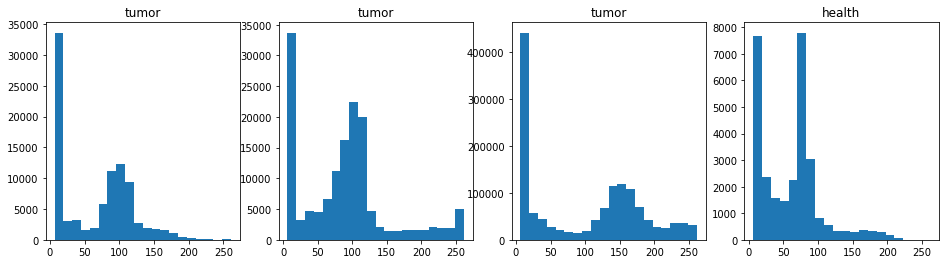

In [44]:
# histograma das imagens de exemplo
bins = 20
plt.figure(figsize=(16, 4))
for i in range(4):
  img = adjust_dimension(dataset['val'][i][0])
  height, x = np.histogram(img, bins=bins)
  plt.subplot(1, 4, i+1)
  plt.bar(x[1::], height, width=np.max(img)/bins)
  plt.title(dataset['val'][i][1])
plt.show()

**2. Local binary pattern (LBP)**

Assim como a função **histogram** a função **local_binary_pattern** tem alguns parâmetros que podem ser alterados: raio, método, número de pontos). Consultem a documentação da bibioteca skimage para mais detalhes. Além disso, lembrem-se que normalmente o LBP não é usado como atributo, mas sim seu histograma.

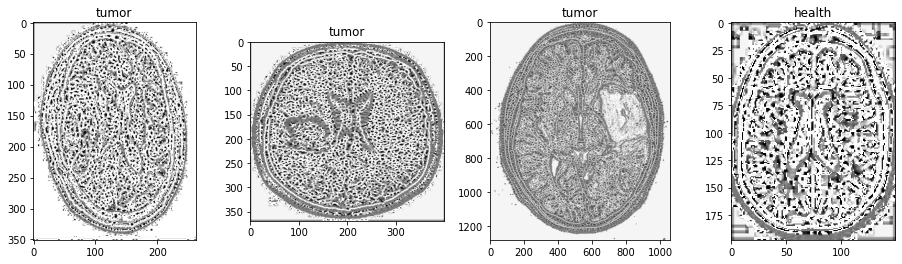

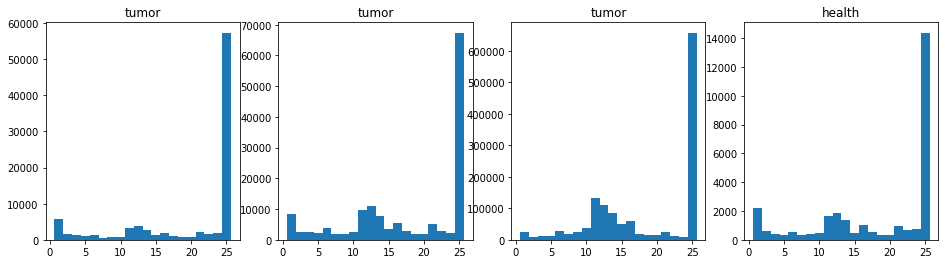

In [45]:
# Exemplo de um extrator de atributos de textura - LBP
from skimage.feature import local_binary_pattern

METHOD = 'uniform'
radius = 3
# radius = 8
n_points = 8 * radius

plt.figure(figsize=(16, 4))
for i in range(4):
  img = adjust_dimension(dataset['val'][i][0])
  lbp = local_binary_pattern(img, n_points, radius, METHOD)
  plt.subplot(1, 4, i+1)
  plt.imshow(lbp, 'gray')
  plt.title(dataset['val'][i][1])
plt.show()


# histograma do LBP

def lbp_histogram(img, bins = 10):
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    return np.histogram(lbp, bins=bins)

plt.figure(figsize=(16, 4))
for i in range(4):
  height, x = lbp_histogram(adjust_dimension(dataset['val'][i][0]), bins=bins)
  plt.subplot(1, 4, i+1)
  plt.bar(x[1::], height, width=np.max(lbp)/bins)
  plt.title(dataset['val'][i][1])
plt.show()

**3. Extraindo os atributos escolhidos dos 3 conjuntos de dados**

O código abaixo extrai todos os atributos selecionados para todos os conjuntos de dados e os coloca na forma de uma tabela de atributos. É importante lembrar que tudo o que for feito em termos de processamento e extração de features deve ser feito da mesma forma nos conjuntos de *treino*, *validação* e *teste*.

In [46]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  train_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  val_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos para o conjunto de teste
print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  test_features.append(lbp_histogram(img, bins=bins)[0])
    
print('exemplo do label de uma imagem de treino = \n', train_labels[0])    
print('exemplo de atributos de uma imagem de treino = \n', train_features[0])

print('exemplo do label de uma imagem de validação = \n', val_labels[0])    
print('exemplo de atributos de uma imagem de validação = \n', val_features[0])

extracting features train ...
extracting features validation ...
extracting features test ...
exemplo do label de uma imagem de treino = 
 health
exemplo de atributos de uma imagem de treino = 
 [ 16108   4854   4552   4232   7136   3632   3970   4781  14228   9540
   8136   5776   8669   4101   4005   4555  10822   5226   4024 143813]
exemplo do label de uma imagem de validação = 
 tumor
exemplo de atributos de uma imagem de validação = 
 [ 5808  1633  1300   949  1287   599   645   725  3271  3879  2851  1318
  1951  1014   740   815  2262  1689  1892 57334]


##**Parte 3 - Treinando o algoritmo para classificar as imagens**

Uma vez de posse de umamatriz de atributos, podemos treinar qualquer classificador supervisionado. Neste exemplo escolhi usar o SVM, que costuma ter um bom desempenho e tem uma função fácil de usar na biblioteca **scikit learn**. É possível trocar o tipo de kernel do SVM (linear, polinomial, RBF), o número de iterações, etc. Consulte a documentação da bilbioteca para maiores informações.

In [47]:
# treinamento do classificador

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=30,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

**1. Usando o classificador treinado para predizer uma amostra do conjunto de validação. Esta etapa pode ser repetida diversas vezes, como forma de escolher os hiperparâmetros do modelo de classificação

In [48]:
# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)


 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']
matriz de confusão = 
 [[ 2 17]
 [ 0 32]]
Sensibilidade

In [49]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_original = Sensibilidade
especificidade_original = Especificidade
acc_original = accuracy_score(test_labels, test_preds)


 Conjunto de Teste 

labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']
matriz de confusão = 
 [[ 1  9]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.1
acc =  0.6538461538461539
--- confusion_matrix ---
[[ 1  9]
 [ 0 16]]

--- classification report ---
              precision    recall  f1-score   support

      health       1.00      0.10      0.18        10
       tumor       0.64      1.00      0.78        16

    accuracy                           0.65        26
   macro avg       0.82      0.55      0.48        26
weighted avg       0.78      0.65      

# Versões

In [50]:
bins = 40

## Versão 0: possui atributos com min, mean, var, std, max-min, max

In [51]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  train_labels.append(label)

  #train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).median(), np.array(img).quantile(), np.array(img).mode(), np.array(img).var(), np.array(img).std(), np.array(img).mad(), np.array(img).max()-np.array(img).min(), np.array(img).max()]))
  train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).var(), np.array(img).std(), np.array(img).max()-np.array(img).min(), np.array(img).max()]))


# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  val_labels.append(label)

  #val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).median(), np.array(img).quantile(), np.array(img).mode(), np.array(img).var(), np.array(img).std(), np.array(img).mad(), np.array(img).max()-np.array(img).min(), np.array(img).max()]))
  val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).var(), np.array(img).std(), np.array(img).max()-np.array(img).min(), np.array(img).max()]))

  
# Extraindo os mesmos atributos para o conjunto de teste
print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  test_labels.append(label)

  #test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).median(), np.array(img).quantile(), np.array(img).mode(), np.array(img).var(), np.array(img).std(), np.array(img).mad(), np.array(img).max()-np.array(img).min(), np.array(img).max()]))
  test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).var(), np.array(img).std(), np.array(img).max()-np.array(img).min(), np.array(img).max()]))

extracting features train ...
extracting features validation ...
extracting features test ...


In [52]:
from sklearn.svm import SVC

# Create the classifier 
svc = SVC(kernel='linear')

# Train the classifier with images and indexes
svc.fit(train_features, train_labels)

# Predict the category of image 
test_preds = svc.predict(test_features)

# Show prediction
print('Result: {}'.format(test_preds))

CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_v0 = Sensibilidade
especificidade_v0 = Especificidade
acc_v0 = accuracy_score(test_labels, test_preds)

Result: ['health' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'health' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'health' 'tumor' 'tumor'
 'health' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'health' 'tumor'
 'tumor']
labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['health' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'health' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'health' 'tumor' 'tumor'
 'health' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'health' 'tumor'
 'tumor']
matriz de confusão = 
 [[ 6  4]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  0.6
acc =  0.7692307692307693
--- confusion_matrix ---
[[ 6  4]
 [ 2 14]]

--- classification report ---
              precision    recall  f1-score   support

      health       0.75      0.60      

## Versão 1: possui atributos com min, mean, max

In [53]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  train_labels.append(label)

  train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  # train_features.append(lbp_histogram(img, bins=bins)[0])


# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  val_labels.append(label)

  val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  # val_features.append(lbp_histogram(img, bins=bins)[0])

  
# Extraindo os mesmos atributos para o conjunto de teste
print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  test_labels.append(label)
  
  test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  # test_features.append(lbp_histogram(img, bins=bins)[0])

extracting features train ...
extracting features validation ...
extracting features test ...


In [54]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)


# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)


# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_v1 = Sensibilidade
especificidade_v1 = Especificidade
acc_v1 = accuracy_score(test_labels, test_preds)


 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'health' 'health' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']
matriz de confusão = 
 [[ 1 18]
 [ 1 31]]
Sensibilidade

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Versão 2: possui atributos com concatenação do histograma com estatisticas

In [55]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  # train_features.append(lbp_histogram(img, bins=bins)[0])


# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  # val_features.append(lbp_histogram(img, bins=bins)[0])

  
# Extraindo os mesmos atributos para o conjunto de teste
print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  # test_features.append(lbp_histogram(img, bins=bins)[0])

extracting features train ...
extracting features validation ...
extracting features test ...


In [56]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)


# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)


# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_v2 = Sensibilidade
especificidade_v2 = Especificidade
acc_v2 = accuracy_score(test_labels, test_preds)


 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor']
matriz de confusão = 
 [[ 1 18]
 [ 0 32]]
Sensibilidade 

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Versão 3: possui atributos com histograma, min, mean, max

In [57]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  #train_features.append(lbp_histogram(img, bins=bins)[0])


# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  #val_features.append(lbp_histogram(img, bins=bins)[0])

  
# Extraindo os mesmos atributos para o conjunto de teste
print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  #test_features.append(lbp_histogram(img, bins=bins)[0])

extracting features train ...
extracting features validation ...
extracting features test ...


In [58]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)


# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)


# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_v3 = Sensibilidade
especificidade_v3 = Especificidade
acc_v3 = accuracy_score(test_labels, test_preds)


 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['health' 'tumor' 'health' 'tumor' 'health' 'health' 'health' 'tumor'
 'tumor' 'tumor' 'health' 'health' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'health' 'tumor' 'health' 'tumor' 'health' 'tumor' 'health'
 'tumor' 'tumor' 'tumor' 'health' 'health' 'health' 'health' 'tumor'
 'tumor' 'health' 'health' 'health' 'health' 'health' 'health' 'tumor'
 'tumor' 'health' 'health' 'health' 'tumor' 'health' 'tumor' 'tumor'
 'health' 'health' 'health']
matriz de confusão = 
 [[12

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Versão 4: igualando o tamanho das imagens

In [59]:
!pip install python-resize-image

In [60]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]

  # Converte os valores inteiros em float para realizar a operação:
  #img = img.astype('float32')

  # Normaliza a faixa de valores:
  #img /= img.max()

  #print(img.size)
  img = image.resize((180,180))
  #print("Nova imagem: ", img.size)
  img = adjust_dimension(img)

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  train_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]

  # Converte os valores inteiros em float para realizar a operação:
  #img = img.astype('float32')

  # Normaliza a faixa de valores:
  #img /= img.max()

  # Resize a imagem ignorando o aspect ratio:
  img = img.resize((180,180))
  img = adjust_dimension(candidate[0])

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  val_features.append(lbp_histogram(img, bins=bins)[0])


# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]

  # Converte os valores inteiros em float para realizar a operação:
  #img = img.astype('float32')

  # Normaliza a faixa de valores:
  #img /= img.max()

  # Resize a imagem ignorando o aspect ratio:
  img = img.resize((180,180))
  img = adjust_dimension(candidate[0])

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  test_features.append(lbp_histogram(img, bins=bins)[0])

extracting features train ...
extracting features validation ...
extracting features test ...


In [61]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)


# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)


print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_v4 = Sensibilidade
especificidade_v4 = Especificidade
acc_v4 = accuracy_score(test_labels, test_preds)


 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']
matriz de confusão = 
 [[ 0 19]
 [ 0 32]]
Sensibilidade =

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Versão 5: normalizando os valores de pixels

In [62]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  train_features.append(lbp_histogram(img, bins=bins)[0])


# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  val_features.append(lbp_histogram(img, bins=bins)[0])


# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  test_features.append(lbp_histogram(img, bins=bins)[0])

extracting features train ...
extracting features validation ...
extracting features test ...


In [63]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)


# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)


print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_v5 = Sensibilidade
especificidade_v5 = Especificidade
acc_v5 = accuracy_score(test_labels, test_preds)


 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'health'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor']
matriz de confusão = 
 [[ 5 14]
 [ 1 31]]
Sensibili

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Versão 6: tamanho iguais e Normalizado

In [64]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]
  # Resize a imagem ignorando o aspect ratio:
  img = image.resize((180,180))
  img = adjust_dimension(img)

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  train_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]
  # Resize a imagem ignorando o aspect ratio:
  img = img.resize((180,180))
  img = adjust_dimension(candidate[0])

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  val_features.append(lbp_histogram(img, bins=bins)[0])


# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]

  # Resize a imagem ignorando o aspect ratio:
  img = img.resize((180,180))
  img = adjust_dimension(candidate[0])

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  test_features.append(lbp_histogram(img, bins=bins)[0])

extracting features train ...
extracting features validation ...
extracting features test ...


In [65]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)


# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)


print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_v6 = Sensibilidade
especificidade_v6 = Especificidade
acc_v6 = accuracy_score(test_labels, test_preds)


 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health']
matri

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

from skimage import feature

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]
  # Resize a imagem ignorando o aspect ratio:
  img = image.resize((180,180))
  img = adjust_dimension(img)

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  # Canny filter
  img = feature.canny(img, sigma=3)

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  train_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]
  # Resize a imagem ignorando o aspect ratio:
  img = img.resize((180,180))
  img = adjust_dimension(candidate[0])

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  # Canny filter
  img = feature.canny(img, sigma=3)

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  val_features.append(lbp_histogram(img, bins=bins)[0])


# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  #img = adjust_dimension(candidate[0])
  img = candidate[0]

  # Resize a imagem ignorando o aspect ratio:
  img = img.resize((180,180))
  img = adjust_dimension(candidate[0])

  # Converte os valores inteiros em float para realizar a operação:
  img = img.astype('float32')

  # Normaliza a faixa de valores:
  img /= img.max()

  # Canny filter
  img = feature.canny(img, sigma=3)

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  test_features.append(lbp_histogram(img, bins=bins)[0])

extracting features train ...
extracting features validation ...
extracting features test ...


In [67]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)


# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)


print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)


 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']
matriz de confusão = 
 [[ 0 19]
 [ 0 32]]
Sensibilidade =

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Classificadores adicionais

In [68]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  train_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  val_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos para o conjunto de teste
print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  test_features.append(lbp_histogram(img, bins=bins)[0])

extracting features train ...
extracting features validation ...
extracting features test ...


## SVC

In [69]:
from sklearn.svm import SVC

# Create the classifier 
svc = SVC(kernel='linear')

# Train the classifier with images and indexes
svc.fit(train_features, train_labels)

# Predict the category of image 
test_preds = svc.predict(test_features)

# Show prediction
print('Result: {}'.format(test_preds))

CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("\n\nSVC")
print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_svc = Sensibilidade
especificidade_svc = Especificidade
acc_svc = accuracy_score(test_labels, test_preds)

Result: ['health' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'health' 'tumor' 'tumor'
 'health' 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'health' 'tumor'
 'health']
labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['health' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'health' 'tumor' 'tumor'
 'health' 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'health' 'tumor'
 'health']
matriz de confusão = 
 [[ 5  5]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  0.5
acc =  0.6923076923076923


SVC
--- confusion_matrix ---
[[ 5  5]
 [ 3 13]]

--- classification report ---
              precision    recall  f1-score   support

      health       0.62      0.5

## GaussianNB

In [70]:
from sklearn.naive_bayes import GaussianNB

# Inicializar nosso classificador
gnb = GaussianNB()

# Treinar nosso classificador
gnb.fit(train_features, train_labels)

# Fazer previsões
test_preds = gnb.predict(test_features)

# Show prediction
print('Result: {}'.format(test_preds))

CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("\n\nGaussianNB")
print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_gaussianNB = Sensibilidade
especificidade_gaussianNB = Especificidade
acc_gaussianNB = accuracy_score(test_labels, test_preds)

Result: ['health' 'tumor' 'health' 'tumor' 'health' 'health' 'health' 'health'
 'health' 'health' 'tumor' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health']
labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['health' 'tumor' 'health' 'tumor' 'health' 'health' 'health' 'health'
 'health' 'health' 'tumor' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health']
matriz de confusão = 
 [[ 8  2]
 [15  1]]
Sensibilidade =  0.0625
Especificidade =  0.8
acc =  0.34615384615384615


GaussianNB
--- confusion_matrix ---
[[ 8  2]
 [15  1]]

--- classification report ---
              precision    recall  f1-score   sup

## MLPClassifier

In [71]:
from sklearn.neural_network import MLPClassifier

# create mutli-layer perceptron classifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

# train
mlp.fit(train_features, train_labels)

# Fazer previsões
test_preds = mlp.predict(test_features)

# Show prediction
print('Result: {}'.format(test_preds))

CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("\n\nMLP")
print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_mlp = Sensibilidade
especificidade_mlp = Especificidade
acc_mlp = accuracy_score(test_labels, test_preds)

Result: ['health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health']
labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health' 'health' 'health' 'health' 'health' 'health' 'health'
 'health' 'health']
matriz de confusão = 
 [[10  0]
 [16  0]]
Sensibilidade =  0.0
Especificidade =  1.0
acc =  0.38461538461538464


MLP
--- confusion_matrix ---
[[10  0]
 [16  0]]

--- classification report ---
              precision    recall  f1-score   support

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
# create mutli-layer perceptron classifier
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(1024, 128), random_state=1,max_iter=150)

# train
mlp.fit(train_features, train_labels)

# Fazer previsões
test_preds = mlp.predict(test_features)

# Show prediction
print('Result: {}'.format(test_preds))

CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("\n\nMLP")
print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

#print("\n\nTesting using MLP")
#print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, test_preds))  
#print('Mean Squared Error:', metrics.mean_squared_error(test_labels, test_preds))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, test_preds))) 

Result: ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']
labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']
matriz de confusão = 
 [[ 1  9]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.1
acc =  0.6538461538461539


MLP
--- confusion_matrix ---
[[ 1  9]
 [ 0 16]]

--- classification report ---
              precision    recall  f1-score   support

      health       1.00      0.10      0.18        

## KNeighborsClassifier

In [73]:
# https://minerandodados.com.br/machine-learning-na-pratica-knn-python/
# https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1031855&gclid=Cj0KCQjwhr2FBhDbARIsACjwLo0RvMg5v1F8IsJfmgtdvYvoWKIHAGNA8KHqt7sDsLbG8cSwpZ6wIq4aAn_zEALw_wcB

from sklearn.neighbors import KNeighborsClassifier

# create mutli-layer perceptron classifier
knn = KNeighborsClassifier(n_neighbors=3)

# train
knn.fit(train_features, train_labels)

# Fazer previsões
test_preds = knn.predict(test_features)

# Show prediction
print('Result: {}'.format(test_preds))

CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("\n\nKNeighbors")
print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_kneighbors = Sensibilidade
especificidade_kneighbors = Especificidade
acc_kneighbors = accuracy_score(test_labels, test_preds)

Result: ['health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor'
 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health']
labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor'
 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health']
matriz de confusão = 
 [[ 4  6]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  0.4
acc =  0.7307692307692307


KNeighbors
--- confusion_matrix ---
[[ 4  6]
 [ 1 15]]

--- classification report ---
              precision    recall  f1-score   support

      health       0.80      0.40

## RandomForestClassifier

In [74]:
# https://www.datacamp.com/community/tutorials/random-forests-classifier-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1031855&gclid=Cj0KCQjwhr2FBhDbARIsACjwLo2lFFYPa_gAwj39lwku2uucZwg2jtWej6A5LoL9AXO3F-j4VxuIF58aAgc1EALw_wcB
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

from sklearn.ensemble import RandomForestClassifier

# create mutli-layer perceptron classifier
rfc = RandomForestClassifier(max_depth=2, random_state=0)

# train
rfc.fit(train_features, train_labels)

# Fazer previsões
test_preds = rfc.predict(test_features)

# Show prediction
print('Result: {}'.format(test_preds))

CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

print("\n\nMLP")
print("--- confusion_matrix ---")
print(confusion_matrix(test_labels, test_preds))  
print("\n--- classification report ---")
print(classification_report(test_labels, test_preds))  
print("\nmodel accuracy: ", accuracy_score(test_labels, test_preds))

sensibilidade_random = Sensibilidade
especificidade_random = Especificidade
acc_random = accuracy_score(test_labels, test_preds)

Result: ['health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'health']
labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['health' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'health']
matriz de confusão = 
 [[ 3  7]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  0.3
acc =  0.6538461538461539


MLP
--- confusion_matrix ---
[[ 3  7]
 [ 2 14]]

--- classification report ---
              precision    recall  f1-score   support

      health       0.60      0.30      0.

In [75]:
# Teste
respostas = clf.predict(test_features)
for i in range(0,len(test_features)):
    classe_real = test_labels[i]
    classe_predita = respostas[i]
    resposta = 'ACERTOU' if classe_real == classe_predita else 'ERROU'
    print('%s: classe real: %s, classe predita: %s. %s!' % (i, classe_real, classe_predita, resposta))

print('-------------------------------------')
acc = accuracy_score(test_labels, respostas, normalize=True) * 100
print('Acuracia: %0.2f%%' % acc)

0: classe real: health, classe predita: tumor. ERROU!
1: classe real: health, classe predita: tumor. ERROU!
2: classe real: health, classe predita: tumor. ERROU!
3: classe real: health, classe predita: tumor. ERROU!
4: classe real: tumor, classe predita: tumor. ACERTOU!
5: classe real: tumor, classe predita: tumor. ACERTOU!
6: classe real: health, classe predita: tumor. ERROU!
7: classe real: tumor, classe predita: tumor. ACERTOU!
8: classe real: tumor, classe predita: tumor. ACERTOU!
9: classe real: tumor, classe predita: tumor. ACERTOU!
10: classe real: tumor, classe predita: tumor. ACERTOU!
11: classe real: tumor, classe predita: tumor. ACERTOU!
12: classe real: health, classe predita: tumor. ERROU!
13: classe real: tumor, classe predita: tumor. ACERTOU!
14: classe real: health, classe predita: tumor. ERROU!
15: classe real: tumor, classe predita: tumor. ACERTOU!
16: classe real: tumor, classe predita: tumor. ACERTOU!
17: classe real: health, classe predita: tumor. ERROU!
18: classe

# Resultados

In [76]:
print('Modelo Original')
print('Sensibilidade: ', sensibilidade_original)
print('Especificidade: ', especificidade_original)
print('Accuracy: ', acc_original)
print('\n\n')

print('Modelo v0')
print('Sensibilidade: ', sensibilidade_v0)
print('Especificidade: ', especificidade_v0)
print('Accuracy: ', acc_v0)
print('\n\n')

print('Modelo v1')
print('Sensibilidade: ', sensibilidade_v1)
print('Especificidade: ', especificidade_v1)
print('Accuracy: ', acc_v1)
print('\n\n')

print('Modelo v2')
print('Sensibilidade: ', sensibilidade_v2)
print('Especificidade: ', especificidade_v2)
print('Accuracy: ', acc_v2)
print('\n\n')

print('Modelo v3')
print('Sensibilidade: ', sensibilidade_v3)
print('Especificidade: ', especificidade_v3)
print('Accuracy: ', acc_v3)
print('\n\n')

print('Modelo v4')
print('Sensibilidade: ', sensibilidade_v4)
print('Especificidade: ', especificidade_v4)
print('Accuracy: ', acc_v4)
print('\n\n')

print('Modelo v5')
print('Sensibilidade: ', sensibilidade_v5)
print('Especificidade: ', especificidade_v5)
print('Accuracy: ', acc_v5)
print('\n\n')

print('Modelo v6')
print('Sensibilidade: ', sensibilidade_v6)
print('Especificidade: ', especificidade_v6)
print('Accuracy: ', acc_v6)
print('\n\n')

print('Modelo SVC')
print('Sensibilidade: ', sensibilidade_svc)
print('Especificidade: ', especificidade_svc)
print('Accuracy: ', acc_svc)
print('\n\n')

print('Modelo GaussianNB')
print('Sensibilidade: ', sensibilidade_gaussianNB)
print('Especificidade: ', especificidade_gaussianNB)
print('Accuracy: ', acc_gaussianNB)
print('\n\n')

print('Modelo MLPClassifier')
print('Sensibilidade: ', sensibilidade_mlp)
print('Especificidade: ', especificidade_mlp)
print('Accuracy: ', acc_mlp)
print('\n\n')

print('Modelo KNeighborsClassifier')
print('Sensibilidade: ', sensibilidade_kneighbors)
print('Especificidade: ', especificidade_kneighbors)
print('Accuracy: ', acc_kneighbors)
print('\n\n')

print('Modelo RandomForestClassifier')
print('Sensibilidade: ', sensibilidade_random)
print('Especificidade: ', especificidade_random)
print('Accuracy: ', acc_random)
print('\n\n')

Modelo Original
Sensibilidade:  1.0
Especificidade:  0.1
Accuracy:  0.6538461538461539



Modelo v0
Sensibilidade:  0.875
Especificidade:  0.6
Accuracy:  0.7692307692307693



Modelo v1
Sensibilidade:  1.0
Especificidade:  0.3
Accuracy:  0.7307692307692307



Modelo v2
Sensibilidade:  1.0
Especificidade:  0.0
Accuracy:  0.6153846153846154



Modelo v3
Sensibilidade:  0.4375
Especificidade:  0.7
Accuracy:  0.5384615384615384



Modelo v4
Sensibilidade:  1.0
Especificidade:  0.0
Accuracy:  0.6153846153846154



Modelo v5
Sensibilidade:  0.875
Especificidade:  0.3
Accuracy:  0.6538461538461539



Modelo v6
Sensibilidade:  0.0
Especificidade:  1.0
Accuracy:  0.38461538461538464



Modelo SVC
Sensibilidade:  0.8125
Especificidade:  0.5
Accuracy:  0.6923076923076923



Modelo GaussianNB
Sensibilidade:  0.0625
Especificidade:  0.8
Accuracy:  0.34615384615384615



Modelo MLPClassifier
Sensibilidade:  0.0
Especificidade:  1.0
Accuracy:  0.38461538461538464



Modelo KNeighborsClassifier
Sensib

Local Binary Pattern for texture classification:

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html?highlight=histogram


GLCM Texture Features: 

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

numpy.histogram:

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

SVM sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

sklearn.metrics:

https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics